In [140]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_absolute_error
import networkx as nx



df = pd.read_csv('CNC_Machine.csv')


In [2]:
df_clean = df.drop(columns=["Unnamed: 0", "filename"], errors='ignore')

In [10]:
df_clean.fillna(df_clean.median(), inplace=True)


In [24]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean)
df_scaled = pd.DataFrame(scaled_data, columns=df_clean.columns)


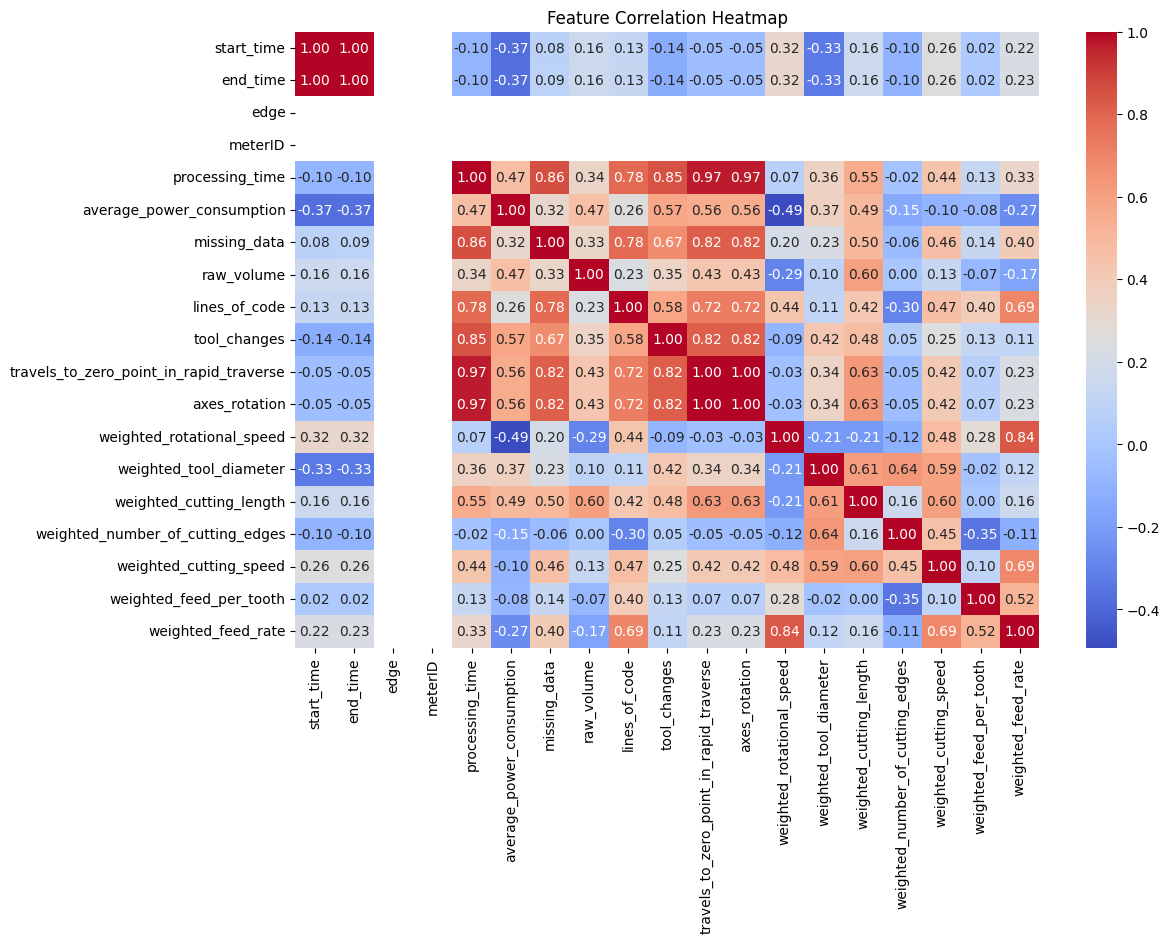

In [8]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_scaled.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [77]:
target_variable = "average_power_consumption"  
X = df_scaled.drop(columns=[target_variable])
y = df_scaled[target_variable]

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [154]:
X_train_tensor = X_train_tensor.double()
y_train_tensor = y_train_tensor.double()
X_val_tensor = X_val_tensor.double()
y_val_tensor = y_val_tensor.double()
X_test_tensor = X_test_tensor.double()
y_test_tensor = y_test_tensor.double()

In [155]:
model = CausalNN(input_size).float()
print(f"Model dtype: {next(model.parameters()).dtype}") 
print(f"Input dtype: {X_train_tensor.dtype}") 

Model dtype: torch.float32
Input dtype: torch.float64


In [127]:
class CausalNN(nn.Module):
    def __init__(self, input_size):
        super(CausalNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x

In [128]:
input_size = X_train.shape[1]
model = CausalNN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)
print(f"Model dtype: {next(model.parameters()).dtype}")
print(f"Input dtype: {X_train_tensor.dtype}")


Model dtype: torch.float64
Input dtype: torch.float64


In [129]:
# epochs = 500
# for epoch in range(epochs):
#     model.train()
#     optimizer.zero_grad()
#     outputs = model(X_train_tensor)
#     loss = criterion(outputs, y_train_tensor)
#     loss.backward()
    
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
#     optimizer.step()
    
#     if epoch % 50 == 0:
#         print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}")

# model.eval()
# with torch.no_grad():
#     predictions = model(X_test_tensor)
#     test_loss = criterion(predictions, y_test_tensor)
#     print(f"Test Loss: {test_loss.item():.4f}")

epochs = 500
best_loss = float('inf')
patience = 20
counter = 0
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        scheduler.step(val_loss)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")



Epoch [0/500], Train Loss: 1.0375, Val Loss: 1.0861
Epoch [50/500], Train Loss: 0.1181, Val Loss: 0.1869
Early stopping at epoch 98


In [130]:
model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [134]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    test_loss = criterion(predictions, y_test_tensor)
    predictions = predictions.numpy()
    
    print(f"\nFinal Test Loss: {test_loss.item():.4f}")
    print(f"R2 Score: {r2_score(y_test, predictions):.4f}")
    print(f"MAE: {mean_absolute_error(y_test, predictions):.4f}")


Final Test Loss: 0.1231
R2 Score: 0.8653
MAE: 0.2485


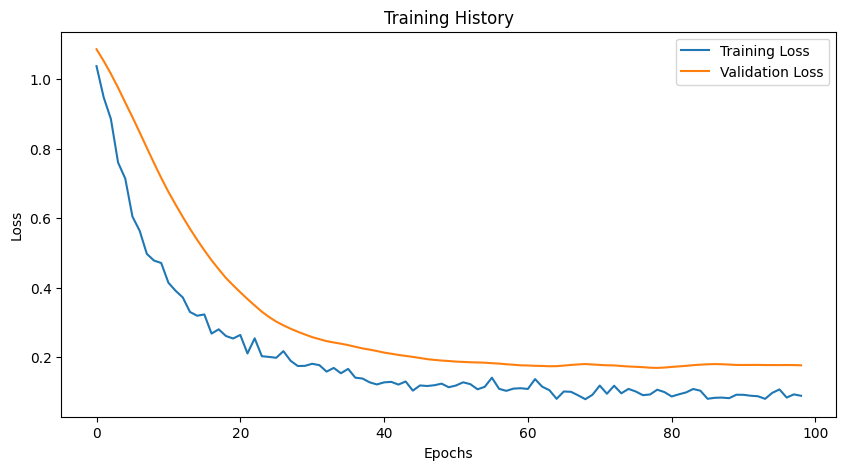

In [135]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.show()


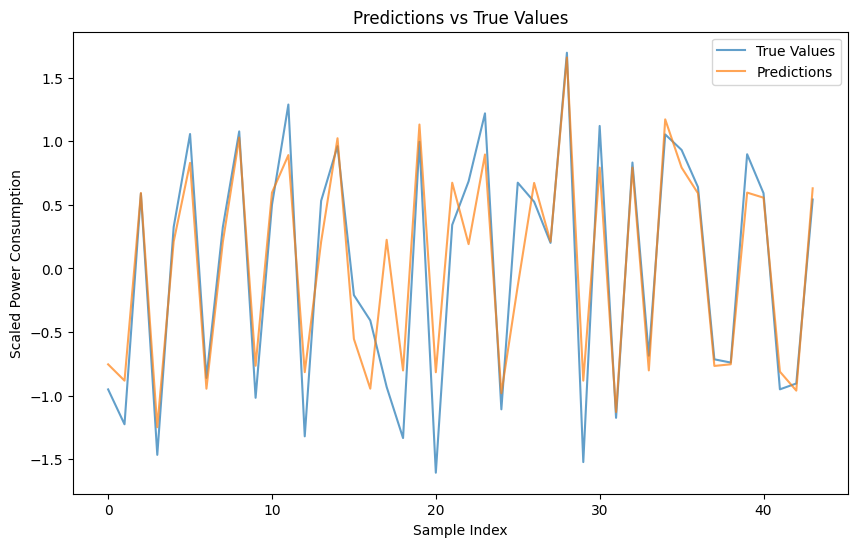

In [136]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='True Values', alpha=0.7)
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Scaled Power Consumption')
plt.title('Predictions vs True Values')
plt.legend()
plt.show()

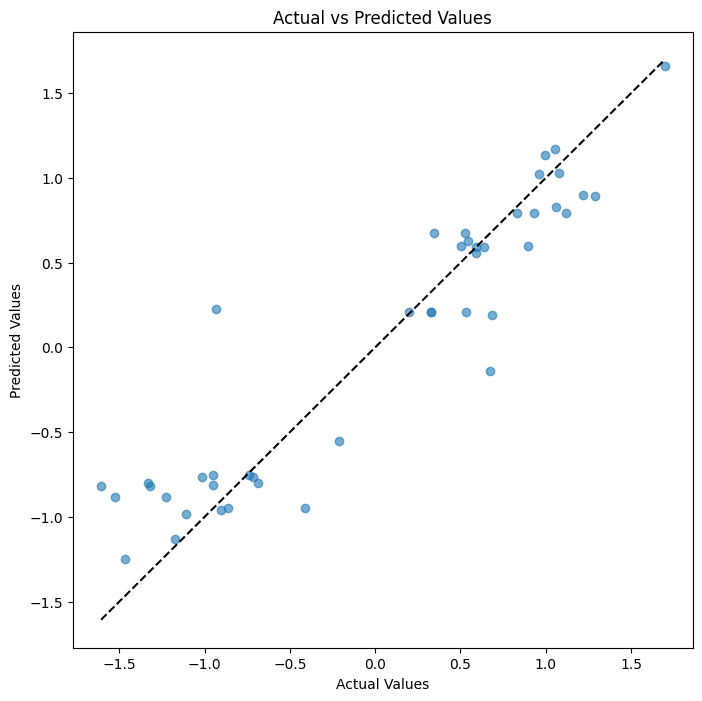

In [137]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, predictions, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()

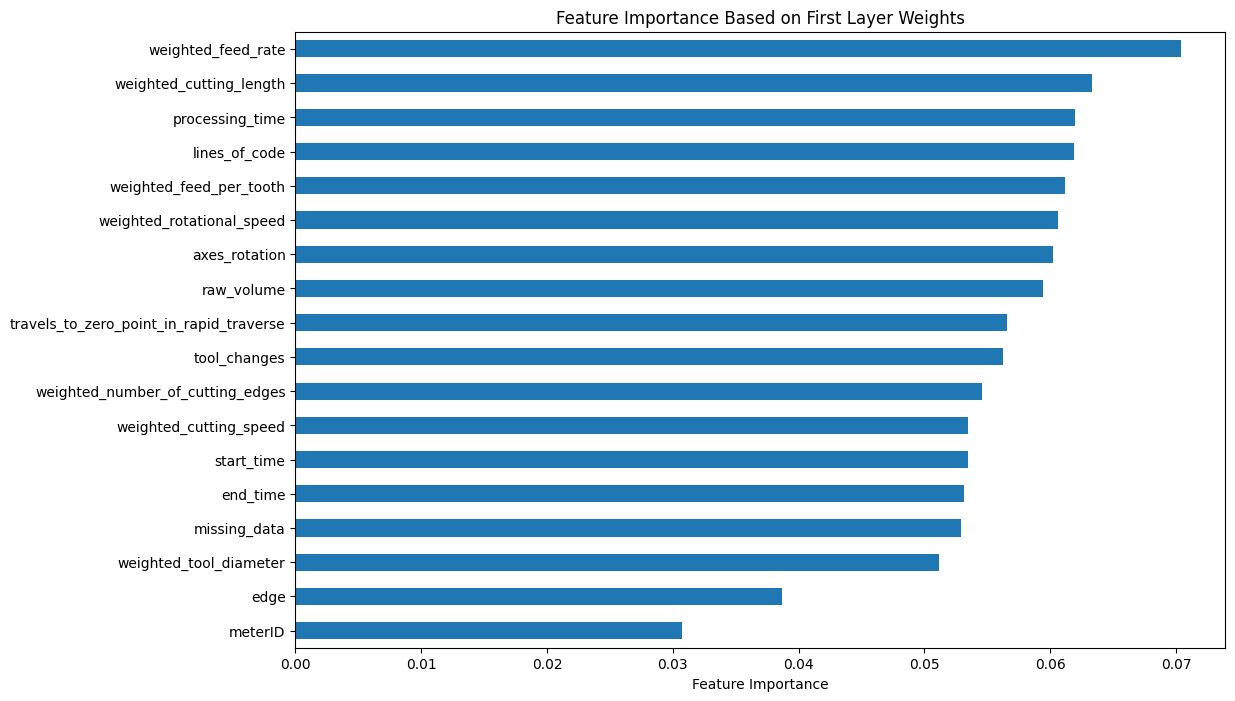

In [138]:
def get_feature_importance(model, feature_names):
    weights = model.fc1.weight.detach().numpy()
    importance = abs(weights).sum(axis=0)
    importance = importance / importance.sum()
    return pd.Series(importance, index=feature_names)

feature_importance = get_feature_importance(model, X_train.columns)
plt.figure(figsize=(12, 8))
feature_importance.sort_values().plot.barh()
plt.xlabel('Feature Importance')
plt.title('Feature Importance Based on First Layer Weights')
plt.show()